# mini-BERT Pretrain Project
한글 위키 데이터를 이용한 BERT 사전학습 프로젝트  

목차:  
1. 

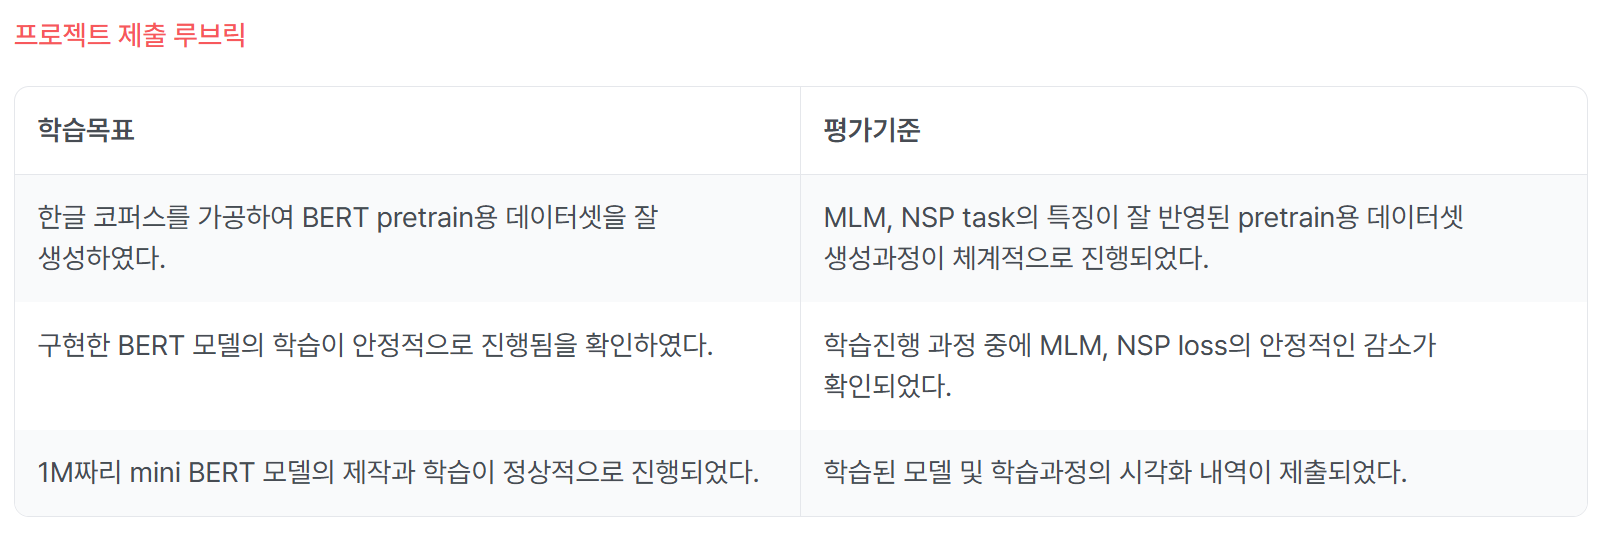

# Section 1. 설정 (config)
1. 라이브러리 로드
2. 시드 고정
3. cofig

In [40]:
import os
import json
import numpy as np
import sentencepiece as spm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

In [117]:
# 시드 고정
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# 설정
CONFIG = {
    # 경로 설정
    "data_dir": "data",
    "corpus_file": "data/kowiki.txt",
    "cleaned_file": "data/kowiki_cleaned.txt",
    "result_file": "models/ablation_results.csv",
    "tokenizer_dir": "tokenizers",
    "model_dir": "models",
    "corpus_file": "data/kowiki.txt",
    "tokenizer_prefix": "tokenizers/ko_8000",

    # 모델 하이퍼파라미터
    "d_model": 256,
    "n_layers": 6,
    "n_heads": 8,
    "d_ff": 1024,
    "dropout": 0.1,

    # 학습 설정
    "vocab_size": 8000,
    "max_len": 128,
    "mask_prob": 0.15,
    "batch_size": 32,
    "epochs": 50,
    "patience": 10,
    "learning_rate": 5e-5,
    "warmup_steps": 1000,
    "train_split": 0.9,  # 5. Validation Split 비율
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "use_amp": True # 3. AMP 사용 여부
}

# 디렉토리 생성
os.makedirs(CONFIG["data_dir"], exist_ok=True)
os.makedirs(CONFIG["tokenizer_dir"], exist_ok=True)
os.makedirs(CONFIG["model_dir"], exist_ok=True)

print(f"Device: {CONFIG['device']}")
print(f"Config: {json.dumps(CONFIG, indent=2, ensure_ascii=False)}")

Device: cuda
Config: {
  "data_dir": "data",
  "corpus_file": "data/kowiki.txt",
  "cleaned_file": "data/kowiki_cleaned.txt",
  "result_file": "models/ablation_results.csv",
  "tokenizer_dir": "tokenizers",
  "model_dir": "models",
  "tokenizer_prefix": "tokenizers/ko_8000",
  "d_model": 256,
  "n_layers": 6,
  "n_heads": 8,
  "d_ff": 1024,
  "dropout": 0.1,
  "vocab_size": 8000,
  "max_len": 128,
  "mask_prob": 0.15,
  "batch_size": 32,
  "epochs": 50,
  "patience": 10,
  "learning_rate": 5e-05,
  "warmup_steps": 1000,
  "train_split": 0.9,
  "device": "cuda",
  "use_amp": true
}


# Section 2. 함수 정의

## Section 2.1 EDA 함수

In [118]:
def perform_eda_and_clean(input_path, output_path, model_dir):
    """
    1. 데이터를 로드하여 결측치와 중복을 제거합니다. (Pandas FutureWarning 수정됨)
    2. 정제된 데이터를 파일로 저장합니다.
    3. 길이 분포를 시각화합니다.
    """
    print(f"\n[EDA & Cleaning] 데이터 분석 및 정제 시작: {input_path}")
    
    if not os.path.exists(input_path):
        print(f"오류: 파일이 존재하지 않습니다 -> {input_path}")
        return

    # 텍스트 파일 읽기
    with open(input_path, 'r', encoding='utf-8') as f:
        lines = [line.strip() for line in f]

    # DataFrame 생성
    df = pd.DataFrame({'text': lines})
    original_len = len(df)
    
    # [수정] Pandas FutureWarning 해결 (inplace=True 제거)
    # 1. 빈 문자열을 NaN으로 변환
    df['text'] = df['text'].replace('', np.nan)
    
    # 2. 결측치(NaN)가 있는 행 제거
    df = df.dropna(subset=['text'])
    
    # 3. 중복 제거
    df = df.drop_duplicates(subset=['text'])
    
    cleaned_len = len(df)
    removed_count = original_len - cleaned_len
    print(f"원본 문장 수: {original_len:,}")
    print(f"제거된 문장 수 (중복/결측): {removed_count:,}")
    print(f"정제 후 문장 수: {cleaned_len:,}")
    
    # 정제된 파일 저장
    with open(output_path, 'w', encoding='utf-8') as f:
        for line in df['text']:
            f.write(line + '\n')
    print(f"정제된 데이터 저장 완료: {output_path}")

    # 길이 분석 (정제된 데이터 기준)
    df['char_len'] = df['text'].apply(len)
    df['word_len'] = df['text'].apply(lambda x: len(x.split()))
    
    print("\n[길이 통계 (정제 후)]")
    print(df[['char_len', 'word_len']].describe().round(2))
    
    # 시각화
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.hist(df['char_len'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    plt.title('Character Length Distribution (Cleaned)')
    plt.xlabel('Length (Chars)')
    plt.ylabel('Count')
    
    plt.subplot(1, 2, 2)
    plt.hist(df['word_len'], bins=50, color='salmon', edgecolor='black', alpha=0.7)
    plt.title('Word Count Distribution (Cleaned)')
    plt.xlabel('Length (Words)')
    plt.ylabel('Count')
    
    plt.tight_layout()
    eda_plot_path = os.path.join(model_dir, "eda_cleaned_distribution.png")
    plt.savefig(eda_plot_path)
    print(f"EDA 그래프 저장 완료: {eda_plot_path}")

## Section 2.2 토크나이저
1. SentencePiece 토크나이저 학습
2. 토크나이저 로드

In [119]:
def train_sentencepiece(corpus_file, prefix, vocab_size):
    if os.path.exists(f"{prefix}.model"):
        print(f"토크나이저가 이미 존재합니다: {prefix}.model")
        return
    
    print("SentencePiece 토크나이저 학습 중...")
    spm.SentencePieceTrainer.train(
        input=corpus_file,
        model_prefix=prefix,
        vocab_size=vocab_size,
        character_coverage=0.9995,
        model_type='bpe',
        pad_id=0, unk_id=1, bos_id=2, eos_id=3,
        user_defined_symbols=['[CLS]', '[SEP]', '[MASK]', '[PAD]']
    )
    print("토크나이저 학습 완료!")

def load_tokenizer(model_path):
    sp = spm.SentencePieceProcessor()
    sp.load(model_path)
    special_tokens = {
        'pad': sp.pad_id(), 'unk': sp.unk_id(),
        'bos': sp.bos_id(), 'eos': sp.eos_id(),
        'cls': sp.piece_to_id('[CLS]'), 'sep': sp.piece_to_id('[SEP]'),
        'mask': sp.piece_to_id('[MASK]')
    }
    return sp, special_tokens

## Section 2.3 데이터 전처리
1. MLM을 위한 마스크 생성
2. NSP를 위한 문장 쌍 생성
3. BERT Pretrain 데이터셋 생성

In [120]:
def create_nsp_data(sentences, max_len, tokenizer, special_tokens):
    """NSP 데이터 생성"""
    instances = []
    
    # 진행률 표시를 위해 tqdm 추가
    for i in tqdm(range(len(sentences) - 1), desc="Dataset Generation"):
        is_next = random.random() < 0.5
        sent_a = sentences[i]
        sent_b = sentences[i + 1] if is_next else sentences[random.randint(0, len(sentences) - 1)]
        label = 1 if is_next else 0
        
        tokens_a = tokenizer.encode_as_ids(sent_a)
        tokens_b = tokenizer.encode_as_ids(sent_b)
        
        # [Fix] Robust Truncation Logic
        # 두 문장의 합이 max_tokens를 넘지 않을 때까지 긴 쪽을 하나씩 제거
        max_tokens = max_len - 3 # [CLS], [SEP], [SEP]
        
        while len(tokens_a) + len(tokens_b) > max_tokens:
            if len(tokens_a) > len(tokens_b):
                tokens_a.pop()
            else:
                tokens_b.pop()
        
        # 토큰 조립
        tokens = [special_tokens['cls']] + tokens_a + [special_tokens['sep']] + tokens_b + [special_tokens['sep']]
        segment_ids = [0] * (len(tokens_a) + 2) + [1] * (len(tokens_b) + 1)
        
        # 패딩 (반드시 max_len에 맞춤)
        padding_len = max_len - len(tokens)
        input_ids = tokens + [special_tokens['pad']] * padding_len
        segment_ids += [0] * padding_len
        
        # 안전장치: 혹시라도 길다면 강제 절삭 (이론상 위에서 처리되지만 안전을 위해)
        if len(input_ids) > max_len:
            input_ids = input_ids[:max_len]
            segment_ids = segment_ids[:max_len]
            
        instances.append({
            'input_ids': input_ids,
            'segment_ids': segment_ids,
            'next_sentence_label': label
        })
    
    return instances
def create_pretrain_dataset(corpus_file, output_file, tokenizer, special_tokens, max_len):
    print("데이터셋 생성 중...")
    with open(corpus_file, 'r', encoding='utf-8') as f:
        lines = [line.strip() for line in f if line.strip()]
    
    dataset = create_nsp_data(lines[:10000], max_len, tokenizer, special_tokens)
    
    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(dataset, f, ensure_ascii=False, indent=2)
    
    print(f"데이터셋 저장 완료: {output_file}")
    return dataset

def analyze_token_lengths(dataset, special_tokens):
    """
    데이터셋의 실제 토큰 길이(Padding 제외)를 분석하고 백분위수를 출력
    """
    print("\n[Token Analysis] 시퀀스별 토큰 수 분포 확인")
    
    # Padding을 제외한 실제 토큰 길이 계산
    pad_id = special_tokens['pad']
    lengths = []
    
    for item in dataset:
        input_ids = np.array(item['input_ids'])
        real_len = np.sum(input_ids != pad_id)
        lengths.append(real_len)
    
    lengths = np.array(lengths)
    
    # 백분위수 계산
    p90 = np.percentile(lengths, 90)
    p95 = np.percentile(lengths, 95)
    p99 = np.percentile(lengths, 99)
    
    print(f"평균 길이: {np.mean(lengths):.2f}")
    print(f"최소 길이: {np.min(lengths)}")
    print(f"최대 길이: {np.max(lengths)} (Max Len 제한: {len(dataset[0]['input_ids'])})")
    print("-" * 30)
    print(f"90% 백분위수: {p90:.2f}")
    print(f"95% 백분위수: {p95:.2f}")
    print(f"99% 백분위수: {p99:.2f}")

## Section 2.4 유틸리티 함수
1. GELU activation


In [121]:
def gelu(x):
    return x * 0.5 * (1.0 + torch.erf(x / np.sqrt(2.0)))

# 모델 파라미타 수 계산
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Early Stop
class EarlyStopping:
    def __init__(self, patience=3, verbose=True, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): 성능이 향상되지 않는 에포크를 얼마나 기다릴지 설정
            verbose (bool): 로그 출력 여부
            delta (float): 개선으로 인정할 최소 변화량
            path (str): 베스트 모델 저장 경로
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''validation loss가 감소하면 모델을 저장한다.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

def save_ablation_result(val_loss, mlm_acc, nsp_acc, file_path):
    """
    실험 결과를 DataFrame으로 만들어 CSV에 누적 저장합니다.
    컬럼: [Ablation_ID, Val_Loss, MLM_Acc, NSP_Acc]
    """
    
    # 파일이 존재하면 로드하여 마지막 ID 확인
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        if not df.empty:
            next_id = df['Ablation_ID'].max() + 1
        else:
            next_id = 1
    else:
        # 파일이 없으면 새로 생성
        df = pd.DataFrame(columns=['Ablation_ID', 'Val_Loss', 'MLM_Acc', 'NSP_Acc'])
        next_id = 1
    
    # 새로운 행 생성
    new_data = {
        'Ablation_ID': [next_id],
        'Val_Loss': [round(val_loss, 6)],
        'MLM_Acc': [round(mlm_acc, 4)],
        'NSP_Acc': [round(nsp_acc, 4)]
    }
    new_df = pd.DataFrame(new_data)
    
    # 합치기 및 저장
    final_df = pd.concat([df, new_df], ignore_index=True)
    final_df.to_csv(file_path, index=False)
    
    print(f"\n[기록 완료] 실험 결과가 저장되었습니다: {file_path}")
    print(final_df.tail(1)) # 방금 저장된 행 출력

## Section 2.5 모델 구현
1. Transformer Encoder Layer
2. BERT Embedding Layer
3. Multi-Head Attention
4. Feed-Forward Network
6. BERT Model
7. BERT for Pretraining

In [122]:
class TransformerEncoderLayer(nn.Module):
    """Pre-LayerNorm Transformer Encoder Layer"""
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super().__init__()
        self.attention = MultiHeadAttention(d_model, n_heads, dropout)
        self.feed_forward = FeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        
    def forward(self, x, mask):
        norm_x = self.norm1(x)
        attn_output = self.attention(norm_x, norm_x, norm_x, mask)
        x = x + self.dropout1(attn_output)
        
        norm_x = self.norm2(x)
        ff_output = self.feed_forward(norm_x)
        x = x + self.dropout2(ff_output)
        
        return x

class BERTEmbedding(nn.Module):
    def __init__(self, vocab_size, d_model, max_len, dropout):
        super().__init__()
        self.token_emb = nn.Embedding(vocab_size, d_model, padding_idx=0)
        self.position_emb = nn.Embedding(max_len, d_model)
        self.segment_emb = nn.Embedding(2, d_model)
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(d_model)
        
    def forward(self, x, segment_ids):
        batch_size, seq_len = x.size()
        pos = torch.arange(seq_len, device=x.device).unsqueeze(0).expand(batch_size, -1)
        embedding = self.token_emb(x) + self.position_emb(pos) + self.segment_emb(segment_ids)
        return self.dropout(self.norm(embedding))

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads, dropout):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, q, k, v, mask=None):
        batch_size = q.size(0)
        Q = self.W_q(q).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        K = self.W_k(k).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        V = self.W_v(v).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        
        scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(self.d_k)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e4)
        attn = self.dropout(F.softmax(scores, dim=-1))
        context = torch.matmul(attn, V).transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        return self.W_o(context)

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        return self.linear2(self.dropout(gelu(self.linear1(x))))

class BERT(nn.Module):
    def __init__(self, vocab_size, d_model, n_layers, n_heads, d_ff, max_len, dropout):
        super().__init__()
        self.embedding = BERTEmbedding(vocab_size, d_model, max_len, dropout)
        self.layers = nn.ModuleList([TransformerEncoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)])
        # Pre-LayerNorm의 경우 마지막에 Norm 추가가 일반적
        self.final_norm = nn.LayerNorm(d_model)
        
    def forward(self, x, segment_ids, mask):
        x = self.embedding(x, segment_ids)
        for layer in self.layers:
            x = layer(x, mask)
        return self.final_norm(x)

class BERTForPretraining(nn.Module):
    def __init__(self, vocab_size, d_model, n_layers, n_heads, d_ff, max_len, dropout):
        super().__init__()
        self.bert = BERT(vocab_size, d_model, n_layers, n_heads, d_ff, max_len, dropout)
        self.mlm_head = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.GELU(),
            nn.LayerNorm(d_model),
            nn.Linear(d_model, vocab_size)
        )
        self.nsp_head = nn.Linear(d_model, 2)
        
    def forward(self, input_ids, segment_ids, attention_mask):
        encoded = self.bert(input_ids, segment_ids, attention_mask)
        mlm_logits = self.mlm_head(encoded)
        nsp_logits = self.nsp_head(encoded[:, 0])
        return mlm_logits, nsp_logits

## Section 2.6 Dataset & Dynamic Masking Collator

In [123]:
class BERTDataset(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # Raw 데이터만 반환, 마스킹은 Collator에서 수행
        item = self.data[idx]
        return {
            'input_ids': torch.LongTensor(item['input_ids']),
            'segment_ids': torch.LongTensor(item['segment_ids']),
            'next_sentence_label': torch.tensor(item['next_sentence_label'], dtype=torch.long)
        }

class DynamicMaskingCollator:
    """ Dynamic Masking을 위한 Collator """
    def __init__(self, tokenizer, mask_prob, vocab_size, special_tokens):
        self.tokenizer = tokenizer
        self.mask_prob = mask_prob
        self.vocab_size = vocab_size
        self.special_tokens = special_tokens

    def __call__(self, batch):
        # 배치 데이터 수집
        input_ids = torch.stack([item['input_ids'] for item in batch])
        segment_ids = torch.stack([item['segment_ids'] for item in batch])
        nsp_labels = torch.stack([item['next_sentence_label'] for item in batch])
        
        # MLM을 위한 라벨 복사 (기본 -100으로 설정)
        labels = input_ids.clone()
        probability_matrix = torch.full(labels.shape, self.mask_prob)
        
        # 특수 토큰 마스킹 제외
        special_token_mask = (input_ids == self.special_tokens['pad']) | \
                             (input_ids == self.special_tokens['cls']) | \
                             (input_ids == self.special_tokens['sep']) | \
                             (input_ids == self.special_tokens['unk']) | \
                             (input_ids == self.special_tokens['bos']) | \
                             (input_ids == self.special_tokens['eos'])
        probability_matrix.masked_fill_(special_token_mask, value=0.0)
        
        # 마스킹 위치 선정
        masked_indices = torch.bernoulli(probability_matrix).bool()
        
        # 라벨 설정 (마스킹 안된 곳은 -100으로 설정하여 Loss 계산 제외)
        labels[~masked_indices] = -100  
        
        # 80% -> [MASK] 토큰
        indices_replaced = torch.bernoulli(torch.full(labels.shape, 0.8)).bool() & masked_indices
        input_ids[indices_replaced] = self.special_tokens['mask']
        
        # 10% -> 랜덤 토큰
        indices_random = torch.bernoulli(torch.full(labels.shape, 0.5)).bool() & masked_indices & ~indices_replaced
        random_words = torch.randint(len(self.special_tokens), self.vocab_size, labels.shape, dtype=torch.long)
        input_ids[indices_random] = random_words[indices_random]
        
        # 나머지 10% -> 원래 토큰 유지 (input_ids 변경 없음)
        
        # Attention Mask 생성
        attention_mask = (input_ids != self.special_tokens['pad']).long()
        
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'segment_ids': segment_ids,
            'mlm_labels': labels,
            'nsp_labels': nsp_labels
        }

## Section 2.7 학습 및 검증 함수
Vectorized Loss & AMP & Validation

In [124]:
def train_epoch(model, dataloader, optimizer, scheduler, scaler, device):
    model.train()
    total_loss = 0
    for batch in tqdm(dataloader, desc="Training"):
        input_ids, segment_ids = batch['input_ids'].to(device), batch['segment_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device).unsqueeze(1).unsqueeze(2)
        mlm_labels, nsp_labels = batch['mlm_labels'].to(device), batch['nsp_labels'].to(device)
        
        with autocast(enabled=CONFIG["use_amp"]):
            mlm_logits, nsp_logits = model(input_ids, segment_ids, attention_mask)
            mlm_loss = F.cross_entropy(mlm_logits.view(-1, CONFIG['vocab_size']), mlm_labels.view(-1), ignore_index=-100)
            nsp_loss = F.cross_entropy(nsp_logits, nsp_labels)
            loss = mlm_loss + nsp_loss
        
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def validate_epoch(model, dataloader, device):
    model.eval()
    total_loss = mlm_correct = mlm_total = nsp_correct = nsp_total = 0
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Validation"):
            input_ids, segment_ids = batch['input_ids'].to(device), batch['segment_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device).unsqueeze(1).unsqueeze(2)
            mlm_labels, nsp_labels = batch['mlm_labels'].to(device), batch['nsp_labels'].to(device)
            
            mlm_logits, nsp_logits = model(input_ids, segment_ids, attention_mask)
            mlm_loss = F.cross_entropy(mlm_logits.view(-1, CONFIG['vocab_size']), mlm_labels.view(-1), ignore_index=-100)
            nsp_loss = F.cross_entropy(nsp_logits, nsp_labels)
            total_loss += (mlm_loss + nsp_loss).item()
            
            mlm_preds = mlm_logits.argmax(dim=-1); mask_indices = (mlm_labels != -100)
            mlm_correct += (mlm_preds[mask_indices] == mlm_labels[mask_indices]).sum().item()
            mlm_total += mask_indices.sum().item()
            nsp_preds = nsp_logits.argmax(dim=-1)
            nsp_correct += (nsp_preds == nsp_labels).sum().item()
            nsp_total += len(nsp_labels)
            
    return total_loss / len(dataloader), mlm_correct / max(1, mlm_total), nsp_correct / max(1, nsp_total)

# Section 3. EDA


[EDA & Cleaning] 데이터 분석 및 정제 시작: data/kowiki.txt
원본 문장 수: 3,957,761
제거된 문장 수 (중복/결측): 1,578,418
정제 후 문장 수: 2,379,343
정제된 데이터 저장 완료: data/kowiki_cleaned.txt

[길이 통계 (정제 후)]
         char_len    word_len
count  2379343.00  2379343.00
mean       118.83       25.83
std        133.59       29.51
min          1.00        1.00
25%         19.00        4.00
50%         79.00       17.00
75%        171.00       37.00
max       9473.00     2135.00
EDA 그래프 저장 완료: data/eda_cleaned_distribution.png


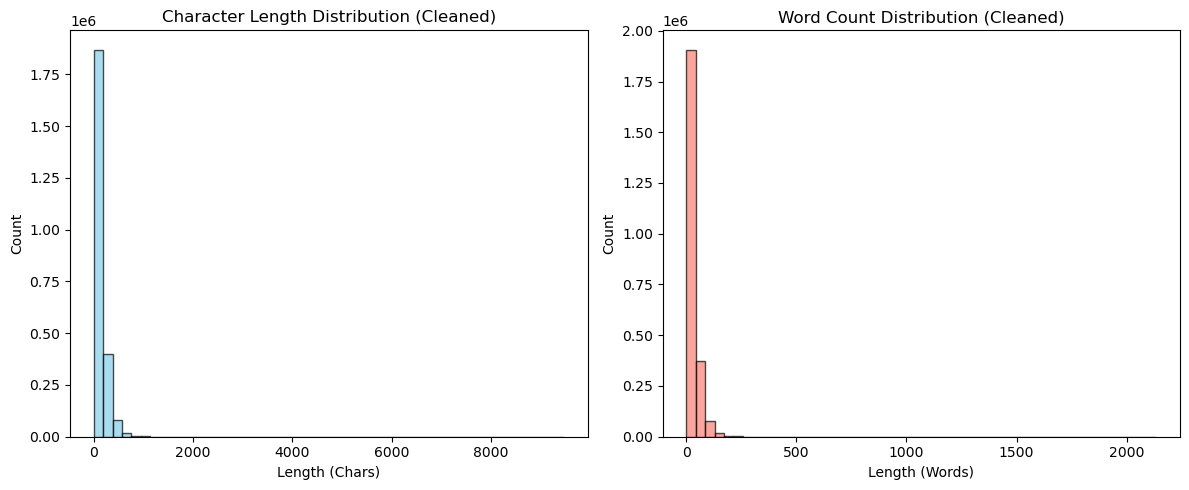

In [125]:
perform_eda_and_clean(CONFIG["corpus_file"], CONFIG["cleaned_file"], CONFIG["data_dir"])

# Section 3. Tokenizer & Dataset 준비

In [66]:
# 토크나이저 학습/로드
train_sentencepiece(CONFIG["cleaned_file"], CONFIG["tokenizer_prefix"], CONFIG["vocab_size"])
tokenizer, special_tokens = load_tokenizer(f"{CONFIG['tokenizer_prefix']}.model")

# 데이터셋 생성
dataset_file = "data/pretrain_data_cleaned.json"
if not os.path.exists(dataset_file):
    dataset_raw = create_pretrain_dataset(CONFIG["cleaned_file"], dataset_file, tokenizer, special_tokens, CONFIG["max_len"])
else:
    print(f"기존 데이터셋 로드: {dataset_file}")
    with open(dataset_file, 'r', encoding='utf-8') as f:
        dataset_raw = json.load(f)

# 토큰 길이 분석
analyze_token_lengths(dataset_raw, special_tokens)

토크나이저가 이미 존재합니다: tokenizers/ko_8000.model
데이터셋 생성 중...


Dataset Generation: 100%|██████████| 9999/9999 [00:02<00:00, 3765.91it/s]


데이터셋 저장 완료: data/pretrain_data_cleaned.json

[Token Analysis] 시퀀스별 토큰 수 분포 확인
평균 길이: 104.68
최소 길이: 5
최대 길이: 128 (Max Len 제한: 128)
------------------------------
90% 백분위수: 128.00
95% 백분위수: 128.00
99% 백분위수: 128.00


# Section 4. DataLoader 생성

In [105]:
full_dataset = BERTDataset(dataset_raw)
train_size = int(len(full_dataset) * CONFIG["train_split"])
val_size = len(full_dataset) - train_size
train_set, val_set = random_split(full_dataset, [train_size, val_size])

collator = DynamicMaskingCollator(tokenizer, CONFIG["mask_prob"], CONFIG["vocab_size"], special_tokens)
train_loader = DataLoader(train_set, batch_size=CONFIG["batch_size"], shuffle=True, collate_fn=collator)
val_loader = DataLoader(val_set, batch_size=CONFIG["batch_size"], shuffle=False, collate_fn=collator)

print(f"Train Batches: {len(train_loader)}")
print(f"Val Batches:   {len(val_loader)}")
print("DataLoader 생성 완료!")

Train Batches: 282
Val Batches:   32
DataLoader 생성 완료!


# Section 5. 모델 초기화

In [111]:
model = BERTForPretraining(
    vocab_size=CONFIG["vocab_size"], d_model=CONFIG["d_model"], n_layers=CONFIG["n_layers"],
    n_heads=CONFIG["n_heads"], d_ff=CONFIG["d_ff"], max_len=CONFIG["max_len"], dropout=CONFIG["dropout"]
).to(CONFIG["device"])

print(f"전체 파라미터 수: {count_parameters(model):,}")
print(f"디바이스: {CONFIG["device"]}")

optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG["learning_rate"])
scaler = torch.amp.GradScaler('cuda', enabled=CONFIG["use_amp"])
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.1, total_iters=CONFIG["warmup_steps"])

early_stopping = EarlyStopping(patience=CONFIG["patience"], verbose=True, path=f"{CONFIG['model_dir']}/bert_best.pt")

전체 파라미터 수: 8,943,682
디바이스: cuda


# Section 6. 모델 학습

In [112]:
history = {'train_loss': [], 'val_loss': [], 'mlm_acc': [], 'nsp_acc': []}

best_val_loss = float('inf')
best_mlm_acc = 0.0
best_nsp_acc = 0.0

print(f"\n학습 시작! (Train: {len(train_set)}, Val: {len(val_set)})")
print("Early Stopping & Ablation Logging 적용")

for epoch in range(CONFIG["epochs"]):
    print(f"\n{'='*30} Epoch {epoch + 1}/{CONFIG['epochs']} {'='*30}")
    train_loss = train_epoch(model, train_loader, optimizer, scheduler, scaler, CONFIG["device"])
    val_loss, mlm_acc, nsp_acc = validate_epoch(model, val_loader, CONFIG["device"])
    
    history['train_loss'].append(train_loss); history['val_loss'].append(val_loss)
    history['mlm_acc'].append(mlm_acc); history['nsp_acc'].append(nsp_acc)
    
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"MLM Acc: {mlm_acc:.4f} | NSP Acc: {nsp_acc:.4f}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_mlm_acc = mlm_acc
        best_nsp_acc = nsp_acc
    
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("\n[알림] Early stopping triggered! 학습을 조기 종료합니다.")
        break
        
print("\n학습 종료. 가장 성능이 좋은 모델은 'models/bert_best.pt'에 저장되었습니다.")


학습 시작! (Train: 8999, Val: 1000)

============================== Epoch 1/50 ==============================


Validation: 100%|██████████| 32/32 [00:01<00:00, 29.88it/s]


Train Loss: 9.4858 | Val Loss: 9.0159
MLM Acc: 0.0281 | NSP Acc: 0.5450

============================== Epoch 2/50 ==============================


Validation: 100%|██████████| 32/32 [00:01<00:00, 28.88it/s]


Train Loss: 8.6152 | Val Loss: 8.2827
MLM Acc: 0.0255 | NSP Acc: 0.5690

============================== Epoch 3/50 ==============================


Validation: 100%|██████████| 32/32 [00:01<00:00, 29.93it/s]


Train Loss: 8.1472 | Val Loss: 8.0493
MLM Acc: 0.0301 | NSP Acc: 0.5450

============================== Epoch 4/50 ==============================


Validation: 100%|██████████| 32/32 [00:01<00:00, 30.25it/s]


Train Loss: 8.0258 | Val Loss: 7.9991
MLM Acc: 0.0294 | NSP Acc: 0.5740

============================== Epoch 5/50 ==============================


Validation: 100%|██████████| 32/32 [00:01<00:00, 30.29it/s]


Train Loss: 8.0106 | Val Loss: 8.0085
MLM Acc: 0.0272 | NSP Acc: 0.5410

============================== Epoch 6/50 ==============================


Validation: 100%|██████████| 32/32 [00:01<00:00, 30.02it/s]


Train Loss: 7.9822 | Val Loss: 7.9864
MLM Acc: 0.0295 | NSP Acc: 0.6040

============================== Epoch 7/50 ==============================


Validation: 100%|██████████| 32/32 [00:01<00:00, 29.81it/s]


Train Loss: 7.9537 | Val Loss: 7.9438
MLM Acc: 0.0352 | NSP Acc: 0.5850

============================== Epoch 8/50 ==============================


Validation: 100%|██████████| 32/32 [00:01<00:00, 29.86it/s]


Train Loss: 7.9342 | Val Loss: 7.8953
MLM Acc: 0.0442 | NSP Acc: 0.6210

============================== Epoch 9/50 ==============================


Validation: 100%|██████████| 32/32 [00:01<00:00, 30.12it/s]


Train Loss: 7.8982 | Val Loss: 7.8800
MLM Acc: 0.0433 | NSP Acc: 0.6190

============================== Epoch 10/50 ==============================


Validation: 100%|██████████| 32/32 [00:01<00:00, 29.98it/s]


Train Loss: 7.8638 | Val Loss: 7.8784
MLM Acc: 0.0492 | NSP Acc: 0.5480

============================== Epoch 11/50 ==============================


Validation: 100%|██████████| 32/32 [00:01<00:00, 29.96it/s]


Train Loss: 7.8329 | Val Loss: 7.8403
MLM Acc: 0.0521 | NSP Acc: 0.5650

============================== Epoch 12/50 ==============================


Validation: 100%|██████████| 32/32 [00:01<00:00, 29.96it/s]


Train Loss: 7.7958 | Val Loss: 7.8060
MLM Acc: 0.0559 | NSP Acc: 0.5960

============================== Epoch 13/50 ==============================


Validation: 100%|██████████| 32/32 [00:01<00:00, 29.82it/s]


Train Loss: 7.7533 | Val Loss: 7.7892
MLM Acc: 0.0614 | NSP Acc: 0.5960

============================== Epoch 14/50 ==============================


Validation: 100%|██████████| 32/32 [00:01<00:00, 29.86it/s]


Train Loss: 7.7118 | Val Loss: 7.8406
MLM Acc: 0.0554 | NSP Acc: 0.5780

============================== Epoch 15/50 ==============================


Validation: 100%|██████████| 32/32 [00:01<00:00, 29.93it/s]


Train Loss: 7.6692 | Val Loss: 7.7808
MLM Acc: 0.0632 | NSP Acc: 0.6040

============================== Epoch 16/50 ==============================


Validation: 100%|██████████| 32/32 [00:01<00:00, 29.82it/s]


Train Loss: 7.6401 | Val Loss: 7.8454
MLM Acc: 0.0591 | NSP Acc: 0.5840

============================== Epoch 17/50 ==============================


Validation: 100%|██████████| 32/32 [00:01<00:00, 30.02it/s]


Train Loss: 7.6037 | Val Loss: 7.8381
MLM Acc: 0.0637 | NSP Acc: 0.5820

============================== Epoch 18/50 ==============================


Validation: 100%|██████████| 32/32 [00:01<00:00, 30.02it/s]


Train Loss: 7.5649 | Val Loss: 7.8794
MLM Acc: 0.0640 | NSP Acc: 0.5860

============================== Epoch 19/50 ==============================


Validation: 100%|██████████| 32/32 [00:01<00:00, 29.81it/s]


Train Loss: 7.5341 | Val Loss: 7.8030
MLM Acc: 0.0676 | NSP Acc: 0.5990

============================== Epoch 20/50 ==============================


Validation: 100%|██████████| 32/32 [00:01<00:00, 29.78it/s]


Train Loss: 7.4846 | Val Loss: 7.8786
MLM Acc: 0.0703 | NSP Acc: 0.5740

============================== Epoch 21/50 ==============================


Validation: 100%|██████████| 32/32 [00:01<00:00, 29.79it/s]


Train Loss: 7.4480 | Val Loss: 7.8976
MLM Acc: 0.0658 | NSP Acc: 0.5960

============================== Epoch 22/50 ==============================


Validation: 100%|██████████| 32/32 [00:01<00:00, 30.01it/s]


Train Loss: 7.4256 | Val Loss: 7.8804
MLM Acc: 0.0720 | NSP Acc: 0.5970

============================== Epoch 23/50 ==============================


Validation: 100%|██████████| 32/32 [00:01<00:00, 29.99it/s]


Train Loss: 7.3863 | Val Loss: 7.9572
MLM Acc: 0.0692 | NSP Acc: 0.5950

============================== Epoch 24/50 ==============================


Validation: 100%|██████████| 32/32 [00:01<00:00, 30.15it/s]


Train Loss: 7.3642 | Val Loss: 7.9302
MLM Acc: 0.0741 | NSP Acc: 0.6110

============================== Epoch 25/50 ==============================


Validation: 100%|██████████| 32/32 [00:01<00:00, 30.18it/s]


Train Loss: 7.3444 | Val Loss: 7.8394
MLM Acc: 0.0765 | NSP Acc: 0.5880

============================== Epoch 26/50 ==============================


Validation: 100%|██████████| 32/32 [00:01<00:00, 30.11it/s]


Train Loss: 7.3062 | Val Loss: 7.9202
MLM Acc: 0.0760 | NSP Acc: 0.6170

============================== Epoch 27/50 ==============================


Validation: 100%|██████████| 32/32 [00:01<00:00, 29.97it/s]


Train Loss: 7.2825 | Val Loss: 8.0194
MLM Acc: 0.0730 | NSP Acc: 0.6120

============================== Epoch 28/50 ==============================


Validation: 100%|██████████| 32/32 [00:01<00:00, 29.78it/s]


Train Loss: 7.2634 | Val Loss: 7.9987
MLM Acc: 0.0769 | NSP Acc: 0.5930

============================== Epoch 29/50 ==============================


Validation: 100%|██████████| 32/32 [00:01<00:00, 30.16it/s]


Train Loss: 7.2276 | Val Loss: 7.9651
MLM Acc: 0.0839 | NSP Acc: 0.5950

============================== Epoch 30/50 ==============================


Validation: 100%|██████████| 32/32 [00:01<00:00, 30.07it/s]


Train Loss: 7.2101 | Val Loss: 8.0012
MLM Acc: 0.0820 | NSP Acc: 0.6030

============================== Epoch 31/50 ==============================


Validation: 100%|██████████| 32/32 [00:01<00:00, 29.92it/s]


Train Loss: 7.1884 | Val Loss: 7.9720
MLM Acc: 0.0849 | NSP Acc: 0.6050

============================== Epoch 32/50 ==============================


Validation: 100%|██████████| 32/32 [00:01<00:00, 30.21it/s]


Train Loss: 7.1466 | Val Loss: 8.0714
MLM Acc: 0.0840 | NSP Acc: 0.5850

============================== Epoch 33/50 ==============================


Validation: 100%|██████████| 32/32 [00:01<00:00, 30.19it/s]


Train Loss: 7.1369 | Val Loss: 7.9596
MLM Acc: 0.0883 | NSP Acc: 0.5960

============================== Epoch 34/50 ==============================


Validation: 100%|██████████| 32/32 [00:01<00:00, 29.78it/s]


Train Loss: 7.1153 | Val Loss: 8.0340
MLM Acc: 0.0843 | NSP Acc: 0.5930

============================== Epoch 35/50 ==============================


Validation: 100%|██████████| 32/32 [00:01<00:00, 29.98it/s]


Train Loss: 7.1034 | Val Loss: 7.9463
MLM Acc: 0.0879 | NSP Acc: 0.6060

============================== Epoch 36/50 ==============================


Validation: 100%|██████████| 32/32 [00:01<00:00, 29.94it/s]


Train Loss: 7.0823 | Val Loss: 8.1207
MLM Acc: 0.0874 | NSP Acc: 0.5930

============================== Epoch 37/50 ==============================


Validation: 100%|██████████| 32/32 [00:01<00:00, 30.07it/s]


Train Loss: 7.0639 | Val Loss: 8.1296
MLM Acc: 0.0863 | NSP Acc: 0.5970

============================== Epoch 38/50 ==============================


Validation: 100%|██████████| 32/32 [00:01<00:00, 29.96it/s]


Train Loss: 7.0539 | Val Loss: 8.0370
MLM Acc: 0.0905 | NSP Acc: 0.5910

============================== Epoch 39/50 ==============================


Validation: 100%|██████████| 32/32 [00:01<00:00, 29.97it/s]


Train Loss: 7.0057 | Val Loss: 8.1824
MLM Acc: 0.0909 | NSP Acc: 0.5980

============================== Epoch 40/50 ==============================


Validation: 100%|██████████| 32/32 [00:01<00:00, 29.81it/s]


Train Loss: 7.0182 | Val Loss: 8.2000
MLM Acc: 0.0909 | NSP Acc: 0.5940

============================== Epoch 41/50 ==============================


Validation: 100%|██████████| 32/32 [00:01<00:00, 29.80it/s]


Train Loss: 6.9837 | Val Loss: 8.1717
MLM Acc: 0.0951 | NSP Acc: 0.5980

============================== Epoch 42/50 ==============================


Validation: 100%|██████████| 32/32 [00:01<00:00, 29.97it/s]


Train Loss: 6.9864 | Val Loss: 7.9925
MLM Acc: 0.0972 | NSP Acc: 0.5930

============================== Epoch 43/50 ==============================


Validation: 100%|██████████| 32/32 [00:01<00:00, 29.92it/s]


Train Loss: 6.9538 | Val Loss: 8.1514
MLM Acc: 0.0962 | NSP Acc: 0.5920

============================== Epoch 44/50 ==============================


Validation: 100%|██████████| 32/32 [00:01<00:00, 29.74it/s]


Train Loss: 6.9487 | Val Loss: 8.1199
MLM Acc: 0.0928 | NSP Acc: 0.6100

============================== Epoch 45/50 ==============================


Validation: 100%|██████████| 32/32 [00:01<00:00, 29.94it/s]


Train Loss: 6.9239 | Val Loss: 8.2786
MLM Acc: 0.1009 | NSP Acc: 0.5750

============================== Epoch 46/50 ==============================


Validation: 100%|██████████| 32/32 [00:01<00:00, 30.09it/s]


Train Loss: 6.9230 | Val Loss: 8.0643
MLM Acc: 0.0987 | NSP Acc: 0.5880

============================== Epoch 47/50 ==============================


Validation: 100%|██████████| 32/32 [00:01<00:00, 29.94it/s]


Train Loss: 6.8752 | Val Loss: 8.2430
MLM Acc: 0.0936 | NSP Acc: 0.6030

============================== Epoch 48/50 ==============================


Validation: 100%|██████████| 32/32 [00:01<00:00, 29.91it/s]


Train Loss: 6.8681 | Val Loss: 8.4549
MLM Acc: 0.0968 | NSP Acc: 0.5730

============================== Epoch 49/50 ==============================


Validation: 100%|██████████| 32/32 [00:01<00:00, 30.14it/s]


Train Loss: 6.8682 | Val Loss: 8.2053
MLM Acc: 0.1034 | NSP Acc: 0.5980

============================== Epoch 50/50 ==============================


Validation: 100%|██████████| 32/32 [00:01<00:00, 30.11it/s]

Train Loss: 6.8449 | Val Loss: 8.2833
MLM Acc: 0.1005 | NSP Acc: 0.6010

학습 종료. 가장 성능이 좋은 모델은 'models/bert_best.pt'에 저장되었습니다.


# Section 7. 결과 시각화

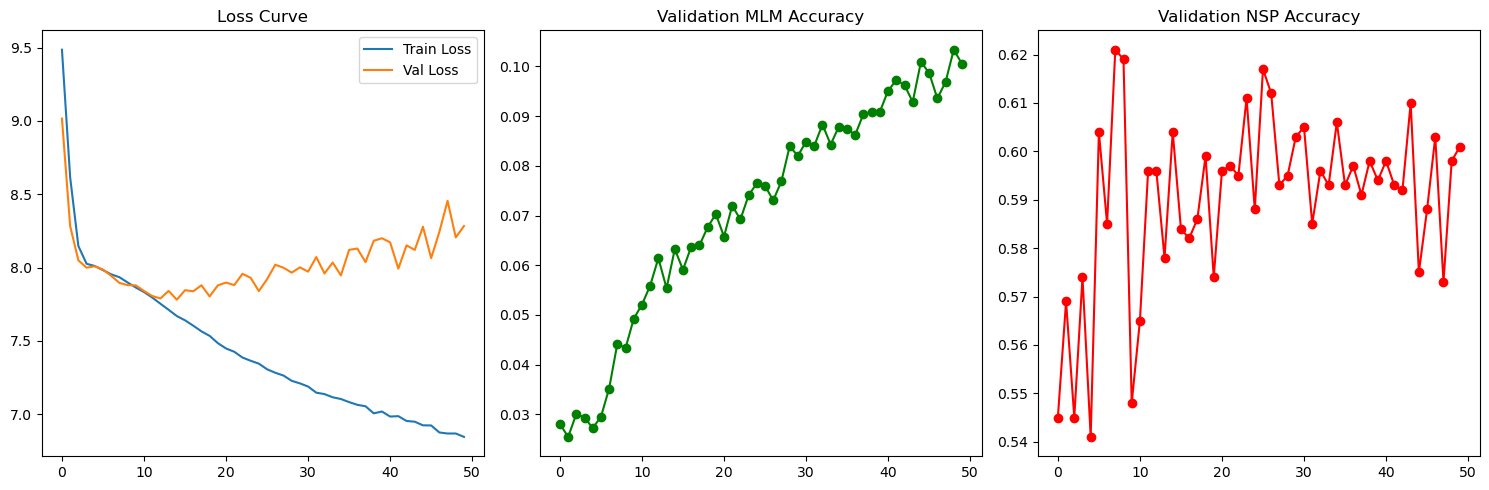

In [113]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss Curve'); plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history['mlm_acc'], 'g-o')
plt.title('Validation MLM Accuracy')

plt.subplot(1, 3, 3)
plt.plot(history['nsp_acc'], 'r-o')
plt.title('Validation NSP Accuracy')

plt.tight_layout()
plt.savefig(f"{CONFIG['model_dir']}/training_history_earlystop.png")
plt.show()

In [126]:
with open(CONFIG["corpus_file"], 'r', encoding='utf-8') as f:
    lines = [line.strip() for line in f]

# DataFrame 생성
df = pd.DataFrame({'text': lines})
len(df)

# [수정] Pandas FutureWarning 해결 (inplace=True 제거)
# 1. 빈 문자열을 NaN으로 변환
# df['text'] = df['text'].replace('', np.nan)

# # 2. 결측치(NaN)가 있는 행 제거
# df = df.dropna(subset=['text'])

# # 3. 중복 제거
# df = df.drop_duplicates(subset=['text'])

# cleaned_len = len(df)
# removed_count = original_len - cleaned_len
# print(f"원본 문장 수: {original_len:,}")
# print(f"제거된 문장 수 (중복/결측): {removed_count:,}")
# print(f"정제 후 문장 수: {cleaned_len:,}")

3957761

In [129]:
df.duplicated()

0          False
1          False
2          False
3          False
4          False
           ...  
3957756    False
3957757    False
3957758     True
3957759     True
3957760     True
Length: 3957761, dtype: bool

In [132]:
df.tail(10)

,text
3957751,"남위 1도는 적도면에서 남쪽으로 5도 떨어진 위선이다. 대서양, 아프리카, 인도양,..."
3957752,남위 1도선은 본초 자오선으로부터 동쪽을 향해 다음 지역들을 통과한다.
3957753,
3957754,
3957755,
3957756,미마우
3957757,미마우는 Twitch와 유튜브에서 방송하는 방송인이다. 트위치에서 Twitch_Mi...
3957758,
3957759,
3957760,


In [134]:
df.isna().sum()

text    1507375
dtype: int64

In [133]:
df['text'] = df['text'].replace('', np.nan)

In [135]:
df = df.dropna(subset=['text'])

In [136]:
df.duplicated().sum()

np.int64(71043)

In [137]:
len(df)

2450386

In [138]:
df[df.duplicated()]

,text
530,여기서
807,이다.
811,"곱셈적 함수 formula_1에 대하여, 만약 formula_13의 소인수 분해가"
812,"일 경우, 다음이 성립한다."
813,"만약 추가로 formula_16가 완전 곱셈적 함수일 경우, 다음이 성립한다."
...,...
3957335,"좋은 직장에 배치받기 위해 주택 취득, 대학 입학, 노동당 가입, 여행 허가 취득을..."
3957336,부패는 궁극적으로 북한 체제의 안정성을 해치는 결과를 가져올 것이며 횡령과 횡령된 ...
3957454,2016년에 입단하였다.
3957455,2018년에 입단하였다.


In [140]:
# 예: 836번 행의 텍스트가 "2009년 9월 3일..." 이라고 가정할 때
search_text = df.loc[530, 'text'] # 혹은 컬럼명
print(df[df['text'] == search_text])

        text
527      여기서
530      여기서
2677     여기서
2696     여기서
2875     여기서
...      ...
3834465  여기서
3846020  여기서
3862586  여기서
3862588  여기서
3876640  여기서

[426 rows x 1 columns]
